In [1]:
import sys, os
# sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'..')))
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
import scipy.integrate as si
import emcee
import corner
import getdist
import warnings
warnings.filterwarnings("ignore")

from HzGPR import H_GPR
from HzFid import H_th
from DA_GPR import DA_Fid

from pathlib import Path
from scipy.optimize import minimize
from IPython.display import display, Math, Latex
from getdist import plots, MCSamples


# Data upload and definition

First we're going to upload the data from the DistData.csv  and from FMGas.csv and extract the relevant quantities. Both measured and calculated ones and their respective errors. 

In [2]:
dados_distancias = pd.read_csv('Saved_Data/DistData.csv', index_col=0)
#dados_distancias

In [3]:
dados_FMG = pd.read_csv('Saved_Data/FMGas.csv')
#dados_FMG

### Some needed parameters values and errors.

In [4]:
# K que é a "calibration Constant" no modelo da fração de massa do gás, e o erro =  ± 0.12
K = 0.96
sigma_K = 0.12

# \gamma é o fator de depleção dos bárions, 
gamma = 0.85
sigma_gamma = 0.085

# \Omega_{b} é o parâmetro de densidade de matéria bariônica, e o erro = ± 0.0039
omega_b = 0.0493
sigma_omega_b = 0.0039

# \Omega_{m} é o parâmetro de densidade de matéria (bariônica + CDM) e o erro = ± 0.0073
omega_m = 0.3153
sigma_omega_m = 0.0073

# \theta , e o erro =  ± 0.035
theta = 0.442
sigma_theta = 0.035

## Distances measures

First the angular diameter distances $d_{A}^{fid}$, $d_{A}^{\, obs}$ and the error associated $\sigma_{d_{A}}^{2}$

In [5]:
dA_fid = np.array(dados_distancias[' dA_fid'])
dA_obs = np.array(dados_distancias['dA_obs'])
dA_obs_erro = np.array(dados_distancias['dA_obs_erro'])

After that, the luminosity distance $d_{L}^{obs}$ and its associated error $\sigma_{d_{L}}^{2}$:

In [6]:
dL_obs = np.array(dados_distancias['dL_obs'])
dL_obs_erro = np.array(dados_distancias['dL_fid_erro'])

and finally, we use the de **CDDR** to get $d_{L}^{fid}$, that is:

$$
d_{L} = \left(1 + z\right)^{2}\cdot d_{A} \,\,\, .
$$

In [7]:
z = np.array(dados_distancias['redshift'])

In [8]:
dL_fid = np.array(dados_distancias['dL_fid'])

## $f_{gas}^{obs}$ measurements,  A(z) and $\bar{f}_{gas}$ :

For the calculation of the $\chi^{2}$ function we need both the measurements of $f_{gas}$, that is $f_{gas}^{obs}$, and the values calculated using the phenomelogical function, $\bar{f}_{gas}$ and the error associated, $\sigma_{f}^{2}$.

In [9]:
fgas_obs = np.array(dados_FMG['gmf_obs'])
fgas_erro = np.array(dados_FMG['gmf_erro'])
fgas_th = np.array(dados_FMG['gmf_bar'])
A = np.array(dados_FMG['A'])

# Função $\chi^{2}$ da Fração de Massa e Cálculo do Erro Médio do modelo 3:

Partido do log da likelihood, temos 


$$
    \ln\,\mathcal{P} \left( y^{\text{th} }\,|\,y^{ \text{ob} },\sigma_{y^{ \text{ob} }}\right) \propto -\frac{1}{2}\chi^2 \left( y^{ \text{th} }\,|\,y^{ \text{ob} },\sigma_{y^{\text{ob} }}\right)  =
    -\frac{1}{2} \sum_n \left[
        \frac{(y^{\text{th} }(z_n)-y^{\text{ob} }_{n})^2}{\sigma_{y^{\text{ob} }_n}^2}
    \right] \,\,\, ,
$$

De modo que para o modelo 2, teremos:

$$
y^{\text{th} }(z_n) = \gamma_0(1+\eta_0z)^{2}\, d_{A}^{\,-1.5}
$$

Assim, para esse modelo, o $\chi^{2}$ será:

$$
\chi^{2}=\sum_{i=1}^{40}\frac{ \left[ \gamma_0(1+\eta_0z)^{2}\, d_{A}^{-1.5}-
\frac{f_{\text{gas},\ i}^{\text{X-ray} } }{ \bar{f}_{gas}} \,\,d_{A}^{* \,-1.5}\,\,\, \right] ^{2}}{\sigma _{\text{
tot},\ i}^{2}}\text{ .}
$$


O erro médio, $\sigma^{2}_{\text{tot}}$ é escrito como:  

$$
\sigma^{2}_{\text{tot}} =  \Sigma_{n} \, \left[ \frac{\partial \, G(X_{n})}{\partial X_{n}}\right]\sigma^{2}_{X_{n}}
$$

considerando que $G(X_{n})= - \frac{ f^{\text{obs}}_{\text{gás}} }{ \bar{f} }$ temos:

$$ 
\sigma^{2}_{\text{tot} } = \left[ \frac{\partial}{\partial f^{ \text{obs}}_{\text{gás}} } \left( - \frac{ f^{\text{obs}}_{\text{gás}} }{ \bar{f}}\right) \right]^{2} \sigma^{2}_{f^{\text{obs}}_{\text{gás}}} + \left[ \frac{\partial}{\partial \bar{f} } \left( - \frac{ f^{\text{obs}}_{\text{gás}} }{ \bar{f}}\right) \right]^{2} \sigma^{2}_{\bar{f}}
$$

e assim,

$$ 
 \sigma^{2}_{\text{tot} } = \frac{1}{\bar{f}^{2} } \sigma^{2}_{f^{\text{obs}} } + \frac{f^{ \text{obs}^{2} } }{\bar{f}^{4} }\sigma^{2}_{\bar{f}}
$$


$$ 
 \sigma^{2}_{\text{tot} } =  \frac{f^{ \text{obs}^{2} } }{\bar{f}^{2} } \left( \frac{ \sigma^{2}_{f^{\text{obs}} }  }{{f}^{\text{obs}^{2}} }  +  \frac{ \sigma^{2}_{\bar{f}}  }{\bar{f}^{2} } \right)
$$

finalmente $ \sigma^{2}_{\bar{f}}$ é dado do mesmo modo:

$$ 
\sigma^{2}_{\bar{f}} =  \Sigma_{m} \, \left[ \frac{\partial \, H(X_{m})}{\partial X_{m}}\right]\sigma^{2}_{X_{n}}
$$

e assim,

$$ 
\sigma^{2}_{\bar{f}} = \left[ \frac{\partial }{\partial K  } \bar{f} \right]^{2} \sigma^{2}_{K} +  \left[ \frac{\partial }{\partial A  } \bar{f} \right]^{2} \sigma^{2}_{A} +  \left[ \frac{\partial }{\partial \Omega_{b}   } \bar{f} \right]^{2} \sigma^{2}_{\Omega_{b}} +  \left[ \frac{\partial }{\partial \Omega_{m}  } \bar{f} \right]^{2} \sigma^{2}_{\Omega_{m}} +  \left[ \frac{\partial }{\partial D^{*}_{A}  } \bar{f} \right]^{2} \sigma^{2}_{D^{*}_{A} } +  \left[ \frac{\partial }{\partial D_{A}   } \bar{f} \right]^{2} \sigma^{2}_{D_{A} } 
$$


Portanto, o erro em relação à $\bar{f}$,


$$
\frac{\sigma^{2}_{ \bar{f} } }{\bar{f}^{2} } = \left[ \frac{ \sigma^{2}_{ K } }{ K^{2} } \, + \, \frac{ \sigma^{2}_{A} }{A^{2}} \, + \,  \frac{\sigma_{\gamma}^{2}}{\gamma^{2} }\, + \frac{ \sigma^{2}_{ \Omega_{b} } }{\Omega_{b}^{2}} \, + \, \sigma^{2}_{\Omega_{m}}\cdot \Omega_{m}^{2} \, + \, \left(\frac{2}{3}\right)^{2} \frac{\sigma^{2}_{D_{A} } }{D_{A}^{2} }  \, \   \right ]
$$

tomando o cuidado de lembrar que:


$$
 \sigma^{2}_{A}  =  \left( \frac{\partial A}{ \partial \theta } \right)^{2} \sigma^{2}_{\theta} 
$$

isto é,

$$
\sigma^{2}_{A} = \left( \mbox{log}\, A\right)^{2} \sigma^{2}_{\theta}
$$

Concluí-se que a expressão final para o erro médio, no primeiro modelo é:

$$
\sigma^{2}_{\text{tot} } = \frac{f^{ \text{obs}^{2} } }{\bar{f}^{2} } \left[ \frac{ \sigma^{2}_{f^{\text{obs}} }  }{{f}^{\text{obs}^{2}} } \, + \, \frac{ \sigma^{2}_{ K } }{ K^{2} } \, + \, \frac{\sigma_{\gamma}^{2}}{\gamma^{2} }\, + \, \frac{\left( \mbox{log}\, A\right)^{2} \sigma^{2}_{\theta}}{A^{2}} \, + \,  \frac{ \sigma^{2}_{ \Omega_{b} } }{\Omega_{b}^{2}} \, + \, \sigma^{2}_{\Omega_{m}}\cdot \Omega_{m}^{2} \, + \, \left(\frac{2}{3}\right)^{2} \frac{\sigma^{2}_{D_{A} } }{D_{A}^{2} } \,    \right ]
$$

## Priors para o modelo 3

Os priors em $\eta$ para o primeiro modelo, serão escolhidos flats (uniformes). Apesar de não informativa a priori tem a vantagem 
de não se fazer suposição qualquer sobre o parâmetro, exceto o range dos valores.


$$
\ln \, \left[\,\mathcal{P}(\Omega_{K}, \gamma_{0}, \eta_{0})\,\right] = \left \{\begin{array}{ll}
        0 \,, & \mbox{ if }\, -5 <\Omega_{K}, \, \gamma_{0},  \, \eta_{0}\,  < 5. \\
        -\infty \,, & \mbox{ outro }
    \end{array}
    \right .
$$

onde, 

$$
-2\ln\mathcal{P} =   \sum_{i=1}^{40}\frac{ \left[  \gamma_0(1+\eta_0z)^{2}\, d_{A}^{\,-1.5}-
\frac{f_{\text{gas},\ i}^{\text{X-ray} } }{ \bar{f}_{gas} } \,\,\,d_{A}^{* \,-1.5} \,\,\,\, \right] ^{2}}{\sigma _{\text{
tot},\ i}^{2}}\,\, +\,\, \sum_{i=1}^{40}\ln 2\pi{\sigma_{\text{tot}, i}^2} 
$$

In [97]:
def LogPrior_mod3(omega_k, gamma_0, eta_0):
    '''
    log likelihood para uma prior não informativa, flat nos parâmetros.
    '''
    
    if  -2 < omega_k <2 and  -3< gamma_0 < 3 and -3 < eta_0 < 3:
        return 0.0

    return -np.inf

In [113]:
def chi2_f_gas_mod3(omega_k, gamma_0, eta_0, dA_obs, A, omega_m, omega_b):
    '''
    chi2_F_gas é a função que calcula o chi-quadrado da fração de massa do gás em
    função dos parâmetros de interesse, omega_k, gamma_0 e eta_0.
    '''
    # razão f^{obs} por \bar{f}
    frac_fgas = fgas_obs/fgas_th
    
    # mudança no d_{A} devido a \Omega_k
    dA_Omega = DA_Fid(omega_k, z)[0]
    
    
    # \sigma^{2}_tot
    sigma_tot_2 = (frac_fgas**2)*(  (fgas_erro/fgas_obs)**2.0 +  (sigma_K/K)**2.0  + (sigma_gamma/gamma)**2.0
                                                                +(sigma_omega_b/omega_b)**2.0 +   (sigma_omega_m*omega_m)**2.0
                                                                + (sigma_theta*np.log(A)/A)**2.0 + ( (2/3)*(dL_obs_erro/dL_obs) )**2    )
        
        
    return  (((gamma_0*(dA_obs**(-1.5))*(1+eta_0*z)**2 - frac_fgas*(dA_Omega)**(-1.5)  )**2.0 ) / sigma_tot_2 ) \
+np.log(2*np.pi*sigma_tot_2) 

In [114]:
%%time
chi2_f_gas_mod3(0, 0.85, 1, dA_obs, A, omega_m, omega_b)

CPU times: user 2.38 ms, sys: 6 µs, total: 2.39 ms
Wall time: 2.39 ms


array([-1.92559776, -1.86964663, -2.09145565, -1.87749645, -1.80949619,
       -1.7860162 , -2.18176374, -2.16718109, -1.42521972, -1.7162435 ,
       -1.74572066, -1.97125147, -1.50299734, -1.61421166, -1.03842916,
       -1.16982548, -1.48266235, -2.04532166, -1.93260926, -1.32207497,
       -1.11658339, -2.17546995, -1.19171708, -1.48610259, -1.66111321,
       -1.84233867, -0.93354444, -2.10009249, -1.64930395, -1.80014419,
       -1.42189051, -1.41683063, -1.32370342, -1.49987718, -1.46199254,
       -0.92932439, -1.58241889, -1.21629959, -1.71410219, -1.52914982])

We want to minimize $\chi^{2}$ via Maximum Likelihood Estimation or **MLE** for short to get the points where we are going to start our walker, in a Monte Carlo-Markov Chain sampling of parameters distribution.

So for the MLE we need to define the log of likelihood function

In [115]:
def LogLikelihood_mod3(vals, dA_Obs, A, omega_m, omega_b):
    
    omega_k, gamma_0, eta_0 = vals
    
    soma = sum(chi2_f_gas_mod3(omega_k, gamma_0, eta_0, dA_Obs, A, omega_m, omega_b))
    
    return -0.5*soma

# MLE for the parameters

Now we code to perform a maximum likelihood estimation, using the scipy.optimize.minimize function to find the values of the parameters omega_k, gamma_0 and eta_0 that minimize the negative log-likelihood of our first model.

To achieve the desired results, we call minimize function passing loglikelihood_fgas1 function, and initial guesses (in_vals) of the values, and include the rest of arguments (args) dA_fid, dA_obs, and A as args.

In [101]:
%%time

loglikelihood = lambda *args: -LogLikelihood_mod3(*args)

in_vals = np.array([0.05, 0.55, 0.5]) + 0.1*np.random.randn(3)

resultado = minimize(loglikelihood, in_vals, args=(dA_obs, A, omega_m, omega_b))

best_omega_k, best_gamma_0, best_eta_0 = resultado.x

print("Maximum likelihood estimates:")
print(f"$\omega_k$ = ", best_omega_k)
print(f"$\gamma_0$ = ", best_gamma_0)
print(f"$\eta_0$ = ", best_eta_0)


Maximum likelihood estimates:
$\omega_k$ =  0.03454824041173167
$\gamma_0$ =  0.6044167234932784
$\eta_0$ =  0.5318457417404799
CPU times: user 10.8 ms, sys: 0 ns, total: 10.8 ms
Wall time: 10.8 ms


In [102]:
MLE_results = [round(best_omega_k, 3), round(best_gamma_0, 3), round(best_eta_0,3)]

# MCMC

Now we are ready to generate samples for the parameters and we're going to do this using emcee.py library and the MLE results as our initial step in the chain.

First we define the total log probability function:

In [103]:
def LogProb_mod3(params):
    
    omega_k, gamma_0, eta_0 = params

    # Flat priors
    LogPrior3 = LogPrior_mod3(omega_k, gamma_0, eta_0)
    if not np.isfinite(LogPrior3):
        return -np.inf
    
    LogProb_tot = LogPrior3 + LogLikelihood_mod3(params, dA_obs, A, omega_m, omega_b)
    
    return LogProb_tot

In [104]:
totalsteps = 10500

param_ini = MLE_results
dim = len(param_ini)

posDist = param_ini + 1e-3 * np.random.randn(16,dim)
n_walkers, n_dim = posDist.shape

sampler_mod3 = emcee.EnsembleSampler(n_walkers, n_dim, LogProb_mod3)

sampler_mod3.run_mcmc(posDist, totalsteps, progress=True);

100%|████████████████████████████████| 10500/10500 [03:08<00:00, 55.85it/s]


In [105]:
print("Mean acceptance fraction: {0:.2f}".format(np.mean(sampler_mod3.acceptance_fraction)))

Mean acceptance fraction: 0.47


## Time Series of random-walks

We create a plot of the walker's time series to observe how it traverses within the parameter space. This helps visualize when the chain becomes stationary, allowing us to determine the optimal interval to perform the burn-in of the sample generated by the algorithm.

Text(0.5, 0, 'Número de Passos')

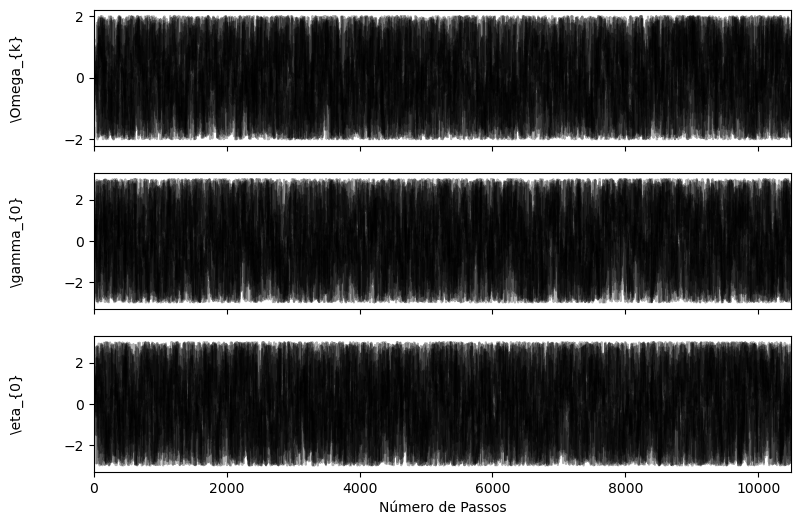

In [106]:
fig, axes = plt.subplots(n_dim, figsize=(9, 6), sharex=True)
samples_mod3 = sampler_mod3.get_chain()
labels_mod3 = [r"\Omega_{k}", r"\gamma_{0}",r"\eta_{0}"]
for i in range(n_dim):
    ax = axes[i]
    ax.plot(samples_mod3[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples_mod3))
    ax.set_ylabel(labels_mod3[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("Número de Passos")

## Burn-In

In [107]:
# tempo de auto-correlação
tau = sampler_mod3.get_autocorr_time()
print(tau)

[75.82300845 74.84800763 73.54464218]


In [108]:
flat_samples_mod3 = sampler_mod3.get_chain(discard=350, thin=15, flat=True)
print("lista Anterior:",sampler_mod3.get_chain().shape)
print("Nova lista:",flat_samples_mod3.shape)

lista Anterior: (10500, 16, 3)
Nova lista: (10816, 3)


In [109]:
np.savetxt("Saved_Data/MCMC_ParamMod3_TESE.csv", flat_samples_mod3, delimiter=",")

# Resultados do Modelo 3 -  
### EEP violation parameter, $\eta$, $\eta(z) = (1+\eta_{0}z)$ gas depletion factor $\gamma_{0} $ constant and $\Omega_{k} \neq 0$ for a non-flat universe.

In [110]:
best_value = []

for i in range(n_dim):
    mcmc_mod3 = np.percentile(flat_samples_mod3[:, i], [25, 50.5, 68])
    best_value.append(mcmc_mod2[1])
    q = np.diff(mcmc_mod2)
    txt = "{{{3}}} = {0:.2f}_{{-{1:.3f}}}^{{+{2:.3f}}}"
    txt = txt.format(mcmc_mod2[1], q[0], q[1], labels_mod3[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [111]:
novo_sample_3 = []
for item in flat_samples_mod3:
    novo_sample_3.append([item[2], item[1], item[0]])

novo_sample_3 = np.array(novo_sample_3)
novo_sample_3

array([[ 0.15900471, -0.42366931,  0.31034415],
       [ 0.02474471, -2.81847166,  1.56743279],
       [ 1.82751271, -0.79280473, -1.14235985],
       ...,
       [ 2.48247854, -1.93682394,  1.46670058],
       [-1.91384427,  1.01931291,  0.20574641],
       [-1.71910436,  2.57220631, -0.57688878]])

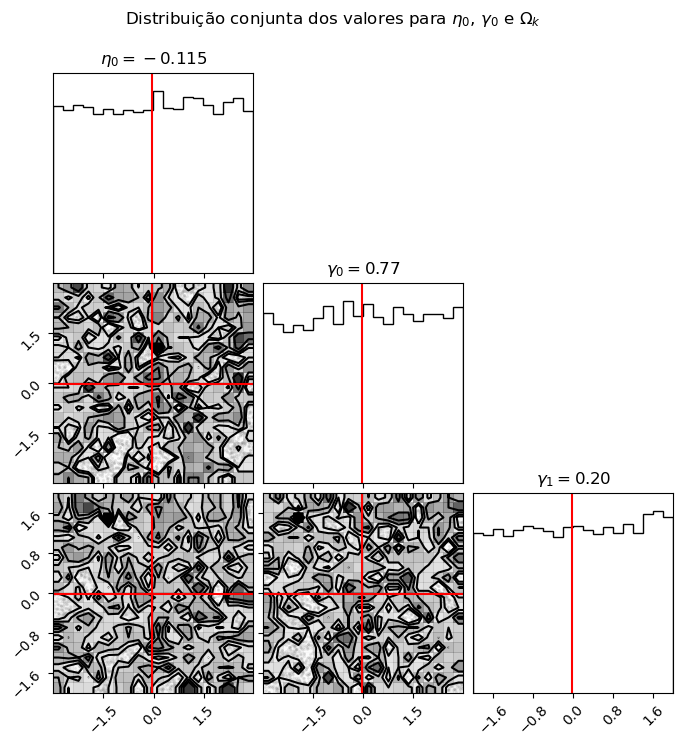

In [112]:
MCMC_flatsamples3 = np.vstack(novo_sample_3)

best_eta = best_value[2]
best_gama_0 = best_value[1]
best_omega_k= best_value[0]

figure = corner.corner(MCMC_flatsamples3, color='black', smooth=0.25, plot_contours =True)
figure.suptitle("\n".join([r'Distribuição conjunta dos valores para $\eta_{0}$, $\gamma_{0}$ e $\Omega_{k}$']), 
                y=1.03)
axes = np.array(figure.axes).reshape((n_dim, n_dim))
axes[0, 0].set_title( r'$\eta_{0}= -0.115$')
axes[0, 0].axvline(x=best_eta, color='r')
axes[1, 1].set_title(r'$\gamma_{0}=0.77$')
axes[1, 0].axvline(x=best_eta, color='r')
axes[1, 0].axhline(y=best_gama_0, color='r')
axes[1, 1].axvline(x=best_gama_0, color = 'r', label = 'axvline - full height')
axes[2, 0].axvline(x=best_eta, color='r')
axes[2, 0].axhline(y=best_omega_k, color='r')
axes[2, 1].axvline(x=best_gama_0, color='r')
axes[2, 1].axhline(y=best_omega_k, color='r')
axes[2,2].set_title(r'$\gamma_{1} = 0.20$')
axes[2,2].axvline(x=best_omega_k, c='r')